In [2]:
# load all the mat files into a dictionary with the names as keys
from pathlib import Path
import scipy.io

path = Path('Forward_and_inverse_xPRA_RTI_codes - Anders/')

mat_data = {}

for mat_file in path.glob('*.mat'):
    data = scipy.io.loadmat(mat_file)
    for key, value in data.items():
        if key not in ['__header__', '__version__', '__globals__']:
            mat_data[key] = value
            if value.shape == (1, 1):
                mat_data[key] = value.item()
            
print(mat_data.keys())

dict_keys(['freq', 'TxRx1', 'size_DOI', 'ty1', 'ym', 'ans', 'distRxRn', 'distTxRn', 'distTxRx', 'E_d', 'E_inc', 'Fryt', 'FrytB', 'Zryt', 'Ptot', 'E_ds1', 'epsono_r_c', 'E_s', 'Pinc', 'TxRxpairs', 'Ni', 'tx1', 'xm', 'epsono_rGT'])


In [3]:
from shapely.geometry import LineString, Point
import numpy as np


def calculate_distance(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)


def get_device_coordinates(parameters):
    doi_size = parameters['doi_size']
    num_deivces = len(parameters['device_indices'])

    # line = LineString(((0.0, 0.0), (0.0, doi_size), (doi_size, doi_size), (doi_size, 0.0), (0.0, 0.0)))
    line = LineString(((-doi_size/2, -doi_size/2), (doi_size/2, -doi_size/2), (doi_size/2, doi_size/2), (-doi_size/2, doi_size/2), (-doi_size/2, -doi_size/2)))

    distances = np.linspace(0, line.length, num_deivces+1)

    points = [line.interpolate(distance) for distance in distances[:-1]]

    coordinates = [[round(point.x, 2), round(point.y, 2)] for point in points]

    return np.array(coordinates)


parameters = {}

parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 30  # dB
parameters['wavelength'] = 3e8/parameters['center_freq']

# imaging parameters
parameters['doi_size'] = 1.5
parameters['alpha'] = 0.05 #1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])) 

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']

    
cellrad = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2
parameters['k0'] = 2*np.pi/parameters['wavelength']



device_coordinates = get_device_coordinates(parameters)


In [4]:
parameters['wavelength']

0.125

In [5]:
def get_grid_coordinates(parameters):
    start = -parameters['doi_size']/2 + parameters['grid_resolution']/2
    end =  abs(start)
    
    x = np.linspace(start, end, parameters['pixel_size'][0])

    y = np.linspace(start, end, parameters['pixel_size'][1])

    grid_coordinates_x, grid_coordinates_y = np.meshgrid(x, y)

    return grid_coordinates_x, grid_coordinates_y


grid_coordinates_x, grid_coordinates_y = get_grid_coordinates(parameters)

In [6]:
xr, xpr = np.meshgrid(device_coordinates[:, 0], grid_coordinates_x.T.reshape(-1))
yr, ypr = np.meshgrid(device_coordinates[:, 1], grid_coordinates_y.T.reshape(-1)[::-1])

distRxRn = np.sqrt((xr-xpr)**2+(yr-ypr)**2).T

In [7]:
from scipy.special import hankel1, jv


Zryt=((1j*np.pi*cellrad/(2*parameters['k0']))*
      jv(1,parameters['k0']*cellrad)*
      hankel1(0, parameters['k0']*distRxRn.T)).T

In [8]:
from functions import *
Pinc = np.load('result/Pinc.npy')
Ptot = np.load('result/Ptot.npy')

Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)


Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [9]:
Pryt=(Ptot-Pinc)/(20*np.log10(np.exp(1)))

In [10]:
dist_txrx = np.zeros((parameters['num_devices'], parameters['num_devices']))
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        dist_txrx[tx][rx] = calculate_distance(device_coordinates[tx], device_coordinates[rx])

In [11]:
from scipy.special import hankel1, jv

E_d = (1j/4)*hankel1(0, parameters['k0']*dist_txrx)
E_inc = (1j/4)*hankel1(0, parameters['k0']*distRxRn)

In [12]:
Fryt = np.zeros((parameters['num_devices']*(parameters['num_devices']-1), parameters['pixel_size'][0]**2), dtype=complex)

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Fryt[idx] = ((parameters['k0']**2)*((Zryt[rx, :]*(E_inc[tx, :]))/(E_d[rx][tx])))
            
            idx += 1

In [13]:
FrytB = np.concatenate((Fryt.real, -Fryt.imag), axis=1)

In [14]:
U_l = FrytB.shape[1]

In [15]:
lambda_max = np.linalg.norm(np.matmul(FrytB.T, Pryt), ord=2)

In [16]:
Oimag = np.matmul(np.linalg.solve((np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l)),  FrytB.T), Pryt)[parameters['pixel_size'][0]**2:]

In [17]:
epr = 4*np.pi*(Oimag*0.5)/parameters['wavelength']

epr[epr < 0] = 0

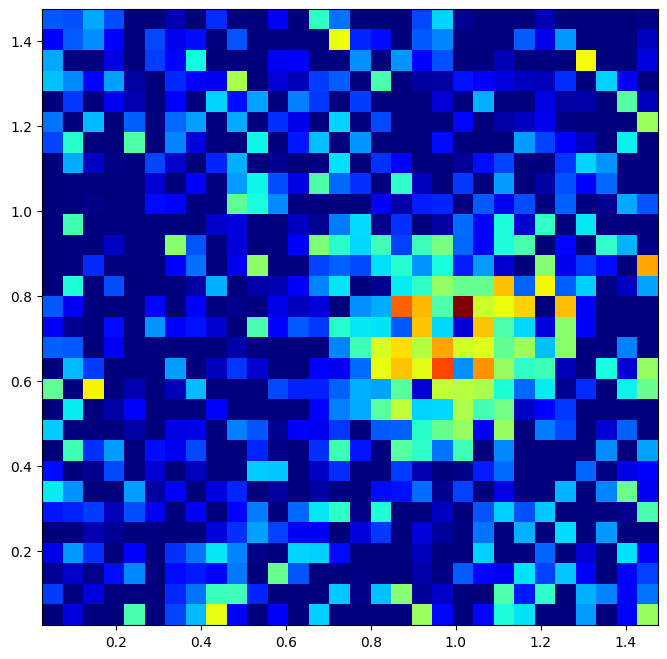

In [18]:

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

epr = np.rot90(epr, k=3)
plt.imshow(epr.reshape(parameters['pixel_size']), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')


plt.show()

In [19]:
epr.max()

3.4543997267130937

In [20]:
parameters['k0']

50.26548245743669

In [21]:
cellrad

0.02820947917738782